In [1]:
# %pip install torchbnn
# %pip install pytorch-lightning
# %pip install tensorboard

In [2]:
import pytorch_lightning as nnl # polars is pl
import matplotlib.pyplot as plt
import torchbnn as bnn
import torch.nn as nn
import seaborn as sns
import pandas as pd
import numpy as np

import itertools
import warnings
import torch

from pytorch_lightning.callbacks import LearningRateFinder, ModelCheckpoint
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from torch.utils.data import DataLoader, TensorDataset, Dataset, random_split
from copy import deepcopy
from IPython.display import Markdown

from wave_generator import WaveGen

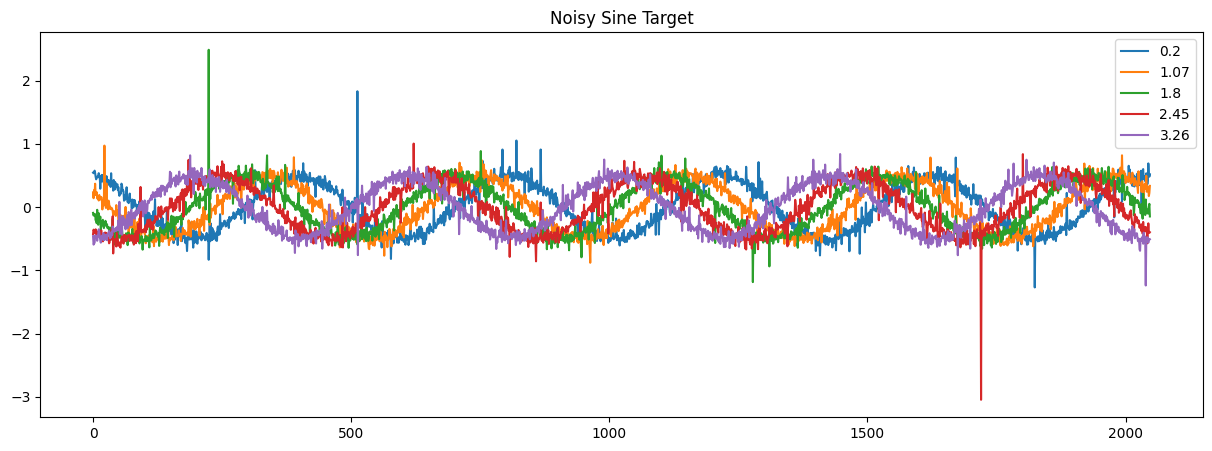

In [3]:
plt.figure(figsize=(15,5))
for phase in [0.2, 1.07, 1.8, 2.45, 3.26]:
    large_wave = WaveGen(size=2048).linear_phase(phase).cos().amp(.5).t_noise(std=.05, dof=3).sample(1).samples.squeeze(axis=0)
    plt.plot(large_wave, label=str(phase))
    
plt.title('Noisy Sine Target')
plt.legend()
plt.show()

In [4]:
def create_ordinal_waves(phases, size=2048):
    waves = list()
    for phase in phases:
        wave = WaveGen(size=size).linear_phase(phase).cos().amp(.5).t_noise(std=.05, dof=3).sample(1).samples.squeeze(axis=0)
        wave = np.diff(wave)
        waves.append(wave)
    continuous_wave = torch.from_numpy(np.stack(waves, axis=1)).float()
    ordinal_wave = torch.argsort(continuous_wave, dim=1).float() / (continuous_wave.shape[1] - 1)
    assert continuous_wave.shape == ordinal_wave.shape
    return continuous_wave, ordinal_wave

size = 4096
phases = [0.2, 1.07, 1.8, 2.45, 3.26]
continuous_wave, ordinal_wave = create_ordinal_waves(phases, size=size)
display(ordinal_wave.shape)

torch.Size([4095, 5])

In [5]:
class ForwardRankDataset(Dataset):
    def __init__(self, continuous_wave, ordinal_wave, pairwise=False, train_length=1, test_length=1, gap=100):
        assert continuous_wave.shape == ordinal_wave.shape, f'Size mismatch, {continuous_wave.shape} != {ordinal_wave.shape}'
        if not ordinal_wave.dim() == 2:
            raise ValueError('Expected 2 dimensional tensor with last dimension shape > 1')
            
        self._length = continuous_wave.shape[0]
        self._output_size = ordinal_wave.shape[1]
        self._unique_indices = list(range(self._output_size))
        self._cont = continuous_wave
        self._rank = ordinal_wave
            
        self.train_length = train_length
        self.test_length = test_length
        self.gap = gap
        self.pairwise = pairwise
        return
    
    @property
    def shape(self):
        return self._length - 1 - self.test_length - self.gap - self.train_length, self._output_size - 1

    def __len__(self):
        return self.shape[0]

    def __getitem__(self, start_idx):
        if isinstance(start_idx, slice):
            raise NotImplementedError('Only integers, not slices, are acceptable')
            
        if self.train_length > 1 or self.test_length > 1:
            in_indices = torch.linspace(
                start_idx, 
                start_idx + self.train_length, 
                self.train_length, 
                dtype=torch.int
            )
            forward_indices = torch.linspace(
                start_idx + self.train_length + self.gap, 
                start_idx + self.train_length + self.gap + self.test_length,
                self.test_length, 
                dtype=torch.int
            )
        else:
            in_indices = start_idx
            forward_indices = start_idx + self.gap + 1
            
        back_data = self._cont[in_indices,:]
        forw_data = self._rank[forward_indices,:]
#         assert back_data.shape == (self.train_length, self._output_size), back_data.shape
#         assert forw_data.shape == (self.test_length, self._output_size), forw_data.shape
        if self.pairwise:
        # this could be much more efficient if it was ranked at the __init__ call
            pair_data = list()
            for i, (idx1, idx2) in enumerate(itertools.combinations(self._unique_indices, 2)):
                pair_data.append(
                    torch.tensor(float(forw_data[idx1] < forw_data[idx2]), requires_grad=True)
                )
            pair_data = torch.tensor(pair_data, requires_grad=True).float()
            return back_data, forw_data, pair_data
        else:
            return back_data, forw_data

In [6]:
import math
import torchmetrics as tm

class BinaryRankAggregator(nn.Module):
    def __init__(
        self,
        n_input_features,
        n_output_features,
        n_hidden_features=16,
        loss='tau',
#         all_weight=.5,
        comb_weight=.5,
    ):
        super(BinaryRankAggregator, self).__init__()
        self.n_input_features = n_input_features
        self.n_output_features = n_output_features
        self.n_hidden_features = n_hidden_features
        assert 0 <= comb_weight <= 1
        self.all_weight = 1 - comb_weight
        self.comb_weight = comb_weight
        
        self.unique_indices = list(range(n_output_features))
        self.subnet_indices = list(itertools.combinations(self.unique_indices, 2))
        self.n_subnets = len(self.subnet_indices)
        assert self.n_subnets < 64, 'That`s a lot of subnets'
        
        self.index_dict = {idx : list() for idx in self.unique_indices}
        
        # Binary Partially Connected Layer
        self.full_subnets = list()    
        for i, (idx1, idx2) in enumerate(self.subnet_indices):
            assert idx1 in self.index_dict
            assert idx2 in self.index_dict
            
            full_subnet = nn.Linear(n_input_features, 1)
            self.full_subnets.append(full_subnet)
            self.index_dict[idx1].append(i)
            self.index_dict[idx2].append(i)
            
        for i, nodes in self.index_dict.items():
            assert len(nodes) == self.n_output_features - 1, f'{len(nodes)} != {self.n_output_features - 1}'
            
        self.partial_subnets = list()
        for i in self.unique_indices:
            partial_subnet = nn.Linear(self.n_output_features - 1, 1)
            self.partial_subnets.append(partial_subnet)
            
#         self.bagg_layer = nn.Linear(self.n_subnets, n_output_features)
        #########################
        
        # Regular Feedforward Net
        self.hinput_layer = nn.Linear(n_input_features, n_hidden_features)
        self.hagg_layer = nn.Linear(n_hidden_features, n_output_features)
        #########################
        
        self.output_layer = nn.Linear(n_output_features, n_output_features)
        
        self.tau_loss = tm.KendallRankCorrCoef(num_outputs=n_output_features)
        self.bin_loss = nn.BCEWithLogitsLoss()
        return

    def partial_forward(self, x):
        initial_features = tuple([full_subnet(x) for full_subnet in self.full_subnets])
        print(initial_features)
        partial_features = list()
        for i, partial_subnet in enumerate(self.partial_subnets):
            partial_feature = torch.cat([initial_features[j] for j in self.index_dict[i]], dim=1)
            partial_features.append(partial_subnet(partial_feature))
            
        feature_x = torch.cat(partial_features, dim=1)
        binary_x = torch.cat(initial_features, dim=1)
        return feature_x, binary_x
    
    def norm(self, x):
        x = (x - torch.min(x))
        x = x / torch.max(x)
        return x
        
    def full_forward(self, x):
        x = self.hinput_layer(x)
        x = self.hagg_layer(x)
        x = self.norm(x)
        return x
    
    def forward(self, x):
        x1 = self.full_forward(x)
        x2, binary_x = self.partial_forward(x)
        x = x1 + x2
        x = self.output_layer(x)
        x = self.norm(x)
        return x, binary_x
    
    def loss(self, all_pred, comb_pred, all_truth, comb_truth):
        tau_loss = -self.tau_loss(all_pred, all_truth)
        bin_loss = self.bin_loss(comb_pred, comb_truth)
        loss = torch.mean(tau_loss * self.all_weight + bin_loss * self.comb_weight)
        return loss

In [8]:
batch_size = 32
train_size = int(size * .8)
test_size = size - train_size - 1
n_epochs = 64

assert continuous_wave.shape == ordinal_wave.shape
continuous_train = continuous_wave[:train_size,:]
ordinal_train = ordinal_wave[:train_size,:]
assert continuous_wave.shape == ordinal_wave.shape

continuous_val = continuous_wave[train_size:,:]
ordinal_val = ordinal_wave[train_size:,:]
assert continuous_wave.shape == ordinal_wave.shape
print('Continuous Wave Shape', continuous_wave.shape)
print('Ordinal Wave Shape', ordinal_wave.shape)

n_features = continuous_wave.shape[1]
print('Number of Features', n_features)

Continuous Wave Shape torch.Size([4095, 5])
Ordinal Wave Shape torch.Size([4095, 5])
Number of Features 5


In [9]:
bra_model = BinaryRankAggregator(
        n_features,
        n_features,
        loss='tau',
        comb_weight=.5,
)

In [10]:
# !pip install graphviz
# !pip install torchviz

from torchviz import make_dot
from IPython.display import Image

x = torch.randn(n_features).unsqueeze(0)
print(x)
make_dot(
    bra_model(x),
    params=dict(bra_model.named_parameters())
).render(
    "ranker_viz", 
    format="png"
)

Image('ranker_viz.png')

tensor([[ 0.7939, -1.2207, -0.7368,  1.9767, -1.6778]])
(tensor([[-1.2266]], grad_fn=<AddmmBackward0>), tensor([[-0.7779]], grad_fn=<AddmmBackward0>), tensor([[0.5154]], grad_fn=<AddmmBackward0>), tensor([[-0.0243]], grad_fn=<AddmmBackward0>), tensor([[-1.0922]], grad_fn=<AddmmBackward0>), tensor([[-2.0417]], grad_fn=<AddmmBackward0>), tensor([[0.2458]], grad_fn=<AddmmBackward0>), tensor([[0.2999]], grad_fn=<AddmmBackward0>), tensor([[-0.5967]], grad_fn=<AddmmBackward0>), tensor([[0.0696]], grad_fn=<AddmmBackward0>))


ExecutableNotFound: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH

In [ ]:
train_dataset = ForwardRankDataset(continuous_train, ordinal_train, pairwise=True)
val_dataset = ForwardRankDataset(continuous_val, ordinal_val, pairwise=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size)
val_loader = DataLoader(val_dataset, batch_size=batch_size)


losss = list()
optimizer = torch.optim.NAdam(bra_model.parameters(), lr=0.01, betas=(0.9, 0.999))

def plot_iteration_loss(train_loss, val_loss, title=''):
    assert len(train_loss) and len(val_loss)
    data = pd.DataFrame({
        'train_loss' : train_loss,
        'validation_loss' : val_loss,
    })

    plt.figure(figsize=(15,5))
    sns.lineplot(data=data, dashes=False)
    plt.title(title)
    plt.show()
    return

epoch_losss = list()
for epoch in range(n_epochs):
    print('Epoch', epoch, end='\r')
    for (train_input, train_forw_output, train_pair_output), (val_input, val_forw_output, val_pair_output) in zip(train_loader, val_loader):
        optimizer.zero_grad()
        train_forw_pred, train_pair_pred = bra_model(train_input)
        loss = bra_model.loss(train_forw_pred, train_pair_pred, train_forw_output, train_pair_output)
        loss.backward()
        optimizer.step()
        
        with torch.no_grad():
            val_forw_pred, val_pair_pred = bra_model(val_input)
            val_loss = bra_model.loss(val_forw_pred, val_pair_pred, val_forw_output, val_pair_output)

        losss.append((loss.item(), val_loss.item()))
        print(len(losss))
#     plot_iteration_loss(losses)
    epoch_train_losss, epoch_val_losss = zip(*losss)
    epoch_losss.append((np.mean(epoch_train_losss), np.mean(epoch_val_losss)))
    losss = list()
    

In [ ]:
all_train_losss, all_val_losss = zip(*epoch_losss)
print(all_train_losss)
plot_iteration_loss(all_train_losss, all_val_losss, title='Epoch Loss')

In [ ]:
class HorizontalRanker(nnl.LightningModule):
    def __init__(
        self,
        n_input_features,
        n_output_features,
        n_hidden_features=16,
        loss_id='tau',
    ):
        super(HorizontalRanker, self).__init__()
        self.input = nn.Linear(n_input_features, n_hidden_features)
        self.activation = nn.ReLU(inplace=True)
        self.hidden = nn.Linear(n_hidden_features, n_hidden_features // 2)
        self.output = nn.Linear(n_hidden_features // 2, n_output_features)
        
        if loss_id == 'tau':
            self.c = tm.KendallRankCorrCoef()
        elif loss_id == 'spearman':
            self.c = tm.SpearmanCorrCoef()
        elif loss_id == 'mae':
            self.c = tm.MeanAbsoluteError()
        elif loss_id == 'contingency':
            self.c = tm.PearsonsContingencyCoefficient(n_output_features)
        elif loss_id == 'ranking_precision':
            self.c = tm.MultilabelRankingAveragePrecision(n_output_features)
        elif loss_id == 'ranking_loss':
            self.c = tm.MultilabelRankingLoss(n_output_features)
        return
    
    def forward(self, x):
        x = self.input(x)
        x = self.activation(x)
        x = self.hidden(x)
        x = self.activation(x)
        x = self.output(x)
#         x = torch.softmax(x)
        return x

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer
    
    def training_step(self, train_batch, batch_idx, min_weight=.05):
        x, y = train_batch
        y_hat = self.forward(x)

        loss = self.c(y_hat, y) # + penalty_term
        self.log('train_loss', loss)
        return loss

    def validation_step(self, val_batch, batch_idx, min_weight=.05):
        x, y = val_batch
        y_hat = self.forward(x)
        
        loss = self.c(y_hat, y)  # + penalty_term
        self.log('val_loss', loss)
        return loss

In [ ]:
train_dataset = ForwardRankDataset(continuous_train, ordinal_train, pairwise=False)
val_dataset = ForwardRankDataset(continuous_val, ordinal_val, pairwise=False)
train_loader = DataLoader(train_dataset, batch_size=batch_size)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

es_callback = EarlyStopping(monitor='val_loss', min_delta=0., patience=5)
lr_callback = LearningRateFinder()
mc_callabck = ModelCheckpoint(dirpath='model_checkpoints/')

print(train_dataset._output_size)
model = HorizontalRanker(
    train_dataset._output_size,
    train_dataset._output_size,
    n_hidden_features=16,
    loss_id='mae',
).float()

trainer = nnl.Trainer(
    precision='bf16-mixed', 
    max_epochs=n_epochs, 
    callbacks=[es_callback]
)
trainer.fit(model, train_loader, val_loader)

In [ ]:
display(Markdown('[Tensorboard](http://localhost:6006/#timeseries)'))
!tensorboard --logdir .